In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Set up

In [3]:
import os
import tqdm

from itertools import combinations, permutations

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_config

from sklearn.model_selection._split import _BaseKFold

## Constants

In [4]:
config = load_config()

In [5]:
PREPROCESSED_DIR = config['preprocessed_data']
FINAL_DIR = config['final_data']

BRAZIL_TRAIN = os.path.join(PREPROCESSED_DIR, 'preprocessed_brazil_train.csv')
BRAZIL_EVAL = os.path.join(PREPROCESSED_DIR, 'preprocessed_brazil_eval.csv')
FRANCE_TRAIN = os.path.join(PREPROCESSED_DIR, 'preprocessed_france_train.csv')
FRANCE_EVAL = os.path.join(PREPROCESSED_DIR, 'preprocessed_france_eval.csv')
MINI_EVAL = os.path.join(PREPROCESSED_DIR, 'preprocessed_mini_brazil_eval.csv')

In [6]:
datasets = {
    'tr_brazil' : BRAZIL_TRAIN,
    'tr_france' : FRANCE_TRAIN,
    'ev_brazil' : BRAZIL_EVAL,
    'ev_france' : FRANCE_EVAL,
    'ev_mini' : MINI_EVAL
}

## Load and view data

In [7]:
df_ = {}
for key, directory in datasets.items():
    df_[key] = pd.read_csv(directory)

/tmp/ipykernel_296316/3510531832.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_[key] = pd.read_csv(directory)
/tmp/ipykernel_296316/3510531832.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_[key] = pd.read_csv(directory)


In [8]:
# df_train_brazil = pd.read_csv(BRAZIL_TRAIN)
# df_train_france = pd.read_csv(FRANCE_TRAIN)

In [9]:
# df_eval_brazil = pd.read_csv(BRAZIL_EVAL)
# df_eval_france = pd.read_csv(FRANCE_EVAL)
# df_eval_mini = pd.read_csv(MINI_EVAL)

### Sanity Checks

In [10]:
# check unique stations in train
df_['tr_brazil'].station_code.nunique(), df_['tr_france'].station_code.nunique()

(9, 30)

In [11]:
# check unique stations in eval
df_['ev_brazil'].station_code.nunique(), df_['ev_france'].station_code.nunique(), df_['ev_mini'].station_code.nunique()

(13, 39, 2)

In [12]:
# check data shape
df_['tr_brazil'].shape, df_['tr_france'].shape

((6579, 175), (21930, 176))

france has one more column than brazil. find the different column

In [13]:
diff_col = set(df_['tr_brazil'].columns).symmetric_difference(set(df_['tr_france'].columns))
diff_col

{'next_downstream_station'}

### Clean and prep
- Filter out non-uniform variables
- drop columns

In [14]:
# remove 'next_downstream_station' from france
for key, directory in datasets.items():
    df_[key] = df_[key].drop(columns = diff_col, errors = 'ignore')
df_['tr_france'].shape, df_['ev_france'].shape

((21930, 175), (5070, 175))

In [15]:
COLS_TO_DROP = ['station_name', 'id_region', 'id_sector', 'id_sub_sector', 'id_zone','geometry', 'eval_only']

In [16]:
for key in df_.keys():
    df_[key] = df_[key].drop(columns = COLS_TO_DROP, errors = 'ignore')
    print(key, df_[key].shape)

tr_brazil (6579, 168)
tr_france (21930, 168)
ev_brazil (1690, 168)
ev_france (5070, 168)
ev_mini (190, 168)


#### Feature engineering strategy
- create temporal features
- categorical features
- PCA soil features to reduce dimensionality
- location encoding
- Train test split before lag/rolling features
- lag features for discharge
- lag features for meteo
- rolling features for meteo

In [17]:
LOCATION = ['longitude', 'latitude']
CATEGORICAL = ['station_code', 'river', 'hydro_region', 'hydro_sector', 'hydro_sub_sector', 'hydro_zone']
NUM_STATION = ['altitude', 'catchment']
NUM_SOIL = ['bdod', 'cfvo', 'clay', 'sand']
NUM_METEO = ['tp', 't2m', 'swvl1', 'evap']
DISCHARGE = 'discharge'
DATE = 'ObsDate'

### Temporal Features

In [18]:
for key in df_.keys():
    # extract df
    temp = df_[key]
    # convert to datetime and temporal features
    temp['ObsDate'] = pd.to_datetime(temp.ObsDate)
    temp['year'] = temp.ObsDate.dt.year
    temp['month'] = temp.ObsDate.dt.month
    temp['week'] = temp.ObsDate.dt.isocalendar().week

    # compute new features 
    # season
    temp['season'] = temp.month.apply(lambda x: (x-1) // 3 + 1) # 1, 2, 3, 4

    # sinusoidial patterns
    sigmas = [4, 8]
    for sigma in sigmas:
        temp[f'gaussian_{sigma}'] =  np.exp(-(((temp.week + 23) % 52 - 52/2) ** 2) / (2 * sigma ** 2))

    # convert to categorical
    temp['year'] = temp.year.astype('category')
    temp['month'] = temp.month.astype('category')
    temp['week'] = temp.week.astype('category')
    temp['season'] = temp.season.astype('category')

### Categorical features

In [19]:
hydro_scale_combinations = list(combinations(['region', 'sector', 'sub_sector', 'zone'], 2))
for key in df_.keys():
    temp = df_[key]
    
    # create hydro feature interaction
    for comb in hydro_scale_combinations:
        col = comb[0] + '_' + comb[1]
        temp[col] = temp.apply(lambda x: str(x[f'hydro_{comb[0]}']) + '_' + str(x[f'hydro_{comb[1]}']), axis = 1).astype('category')
        
    # convert other categorical vars to category
    for col in CATEGORICAL:
        temp[col] = temp[col].astype('category')

### Location Encoding

In [20]:
def encode_location(lat, lon):
    lat_rad = np.radians(lat)  # Convert to radians
    lon_rad = np.radians(lon)
    
    lat_sin = np.sin(lat_rad)
    lat_cos = np.cos(lat_rad)
    lon_sin = np.sin(lon_rad)
    lon_cos = np.cos(lon_rad)
    
    location_encoding = pd.Series([lat_sin, lat_cos, lon_sin, lon_cos])
    return location_encoding

In [21]:
for key in df_.keys():
    temp = df_[key]
    temp[['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']] = temp.apply(lambda x: encode_location(x.latitude, x.longitude), axis = 1)

### combine datasets

In [22]:
# assign country
for key in df_.keys():
    location = key.split('_')[-1]
    dataset = key.split('_')[0]
    if location == 'mini':
        location = 'brazil'
        dataset = 'mini'
    df_[key]['location'] = location
    if dataset == 'tr':
        continue
    df_[key]['dataset'] = dataset

In [23]:
df_train = pd.concat([df_['tr_brazil'], df_['tr_france']], ignore_index = True)
df_eval = pd.concat([df_['ev_brazil'], df_['ev_france'], df_['ev_mini']], ignore_index = True)

In [24]:
df_train

,station_code,ObsDate,tp,tp_50km,tp_100km,t2m,t2m_50km,t2m_100km,swvl1,swvl1_50km,...,region_sub_sector,region_zone,sector_sub_sector,sector_zone,sub_sector_zone,lat_sin,lat_cos,lon_sin,lon_cos,location
0,56960005,1990-01-07,6.853062e-05,0.000066,0.000065,294.95035,295.69116,296.34665,0.437288,0.439239,...,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,-0.344817,0.938670,-0.668626,0.743599,brazil
1,56960005,1990-01-14,1.560804e-05,0.000015,0.000010,295.11826,296.01965,296.87080,0.381397,0.380927,...,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,-0.344817,0.938670,-0.668626,0.743599,brazil
2,56960005,1990-01-21,5.732055e-07,0.000001,0.000002,295.49854,296.43423,297.25690,0.314188,0.314730,...,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,-0.344817,0.938670,-0.668626,0.743599,brazil
3,56960005,1990-01-28,8.079637e-05,0.000072,0.000072,296.61980,297.49094,298.22810,0.326036,0.322331,...,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,-0.344817,0.938670,-0.668626,0.743599,brazil
4,56960005,1990-02-04,1.040163e-05,0.000015,0.000016,295.95758,296.61862,297.09190,0.320605,0.317153,...,1351936_1351043,1351936_1345662,1351808_1351043,1351808_1345662,1351043_1345662,-0.344817,0.938670,-0.668626,0.743599,brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28504,6139795,2003-12-07,1.788707e-05,0.000021,0.000041,278.38266,278.22693,278.12973,0.386718,0.390910,...,U_U26,U_U261,U2_U26,U2_U261,U26_U261,0.731720,0.681606,0.103780,0.994600,france
28505,6139795,2003-12-14,1.555908e-04,0.000136,0.000110,277.25555,276.99426,276.71866,0.379990,0.383507,...,U_U26,U_U261,U2_U26,U2_U261,U26_U261,0.731720,0.681606,0.103780,0.994600,france
28506,6139795,2003-12-21,2.325291e-04,0.000216,0.000189,275.85210,275.89142,276.19020,0.402066,0.400608,...,U_U26,U_U261,U2_U26,U2_U261,U26_U261,0.731720,0.681606,0.103780,0.994600,france
28507,6139795,2003-12-28,1.206086e-04,0.000106,0.000089,273.75018,273.69955,274.08600,0.394825,0.397471,...,U_U26,U_U261,U2_U26,U2_U261,U26_U261,0.731720,0.681606,0.103780,0.994600,france


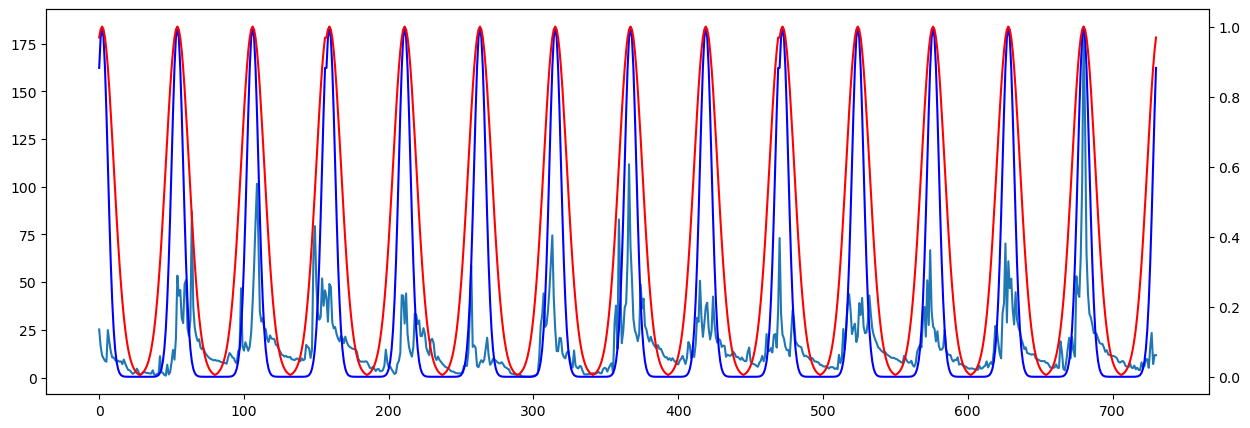

In [25]:
sc = df_train.station_code.unique()[0]
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(df_train[df_train.station_code == sc].discharge)
ax2 = ax.twinx()
# ax2.plot(samp[samp.station_code == sc].tp, color = 'r')
ax2.plot(df_train[df_train.station_code == sc].gaussian_4, color = 'b')
ax2.plot(df_train[df_train.station_code == sc].gaussian_8, color = 'r');

#### Lag and rolling Features

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf

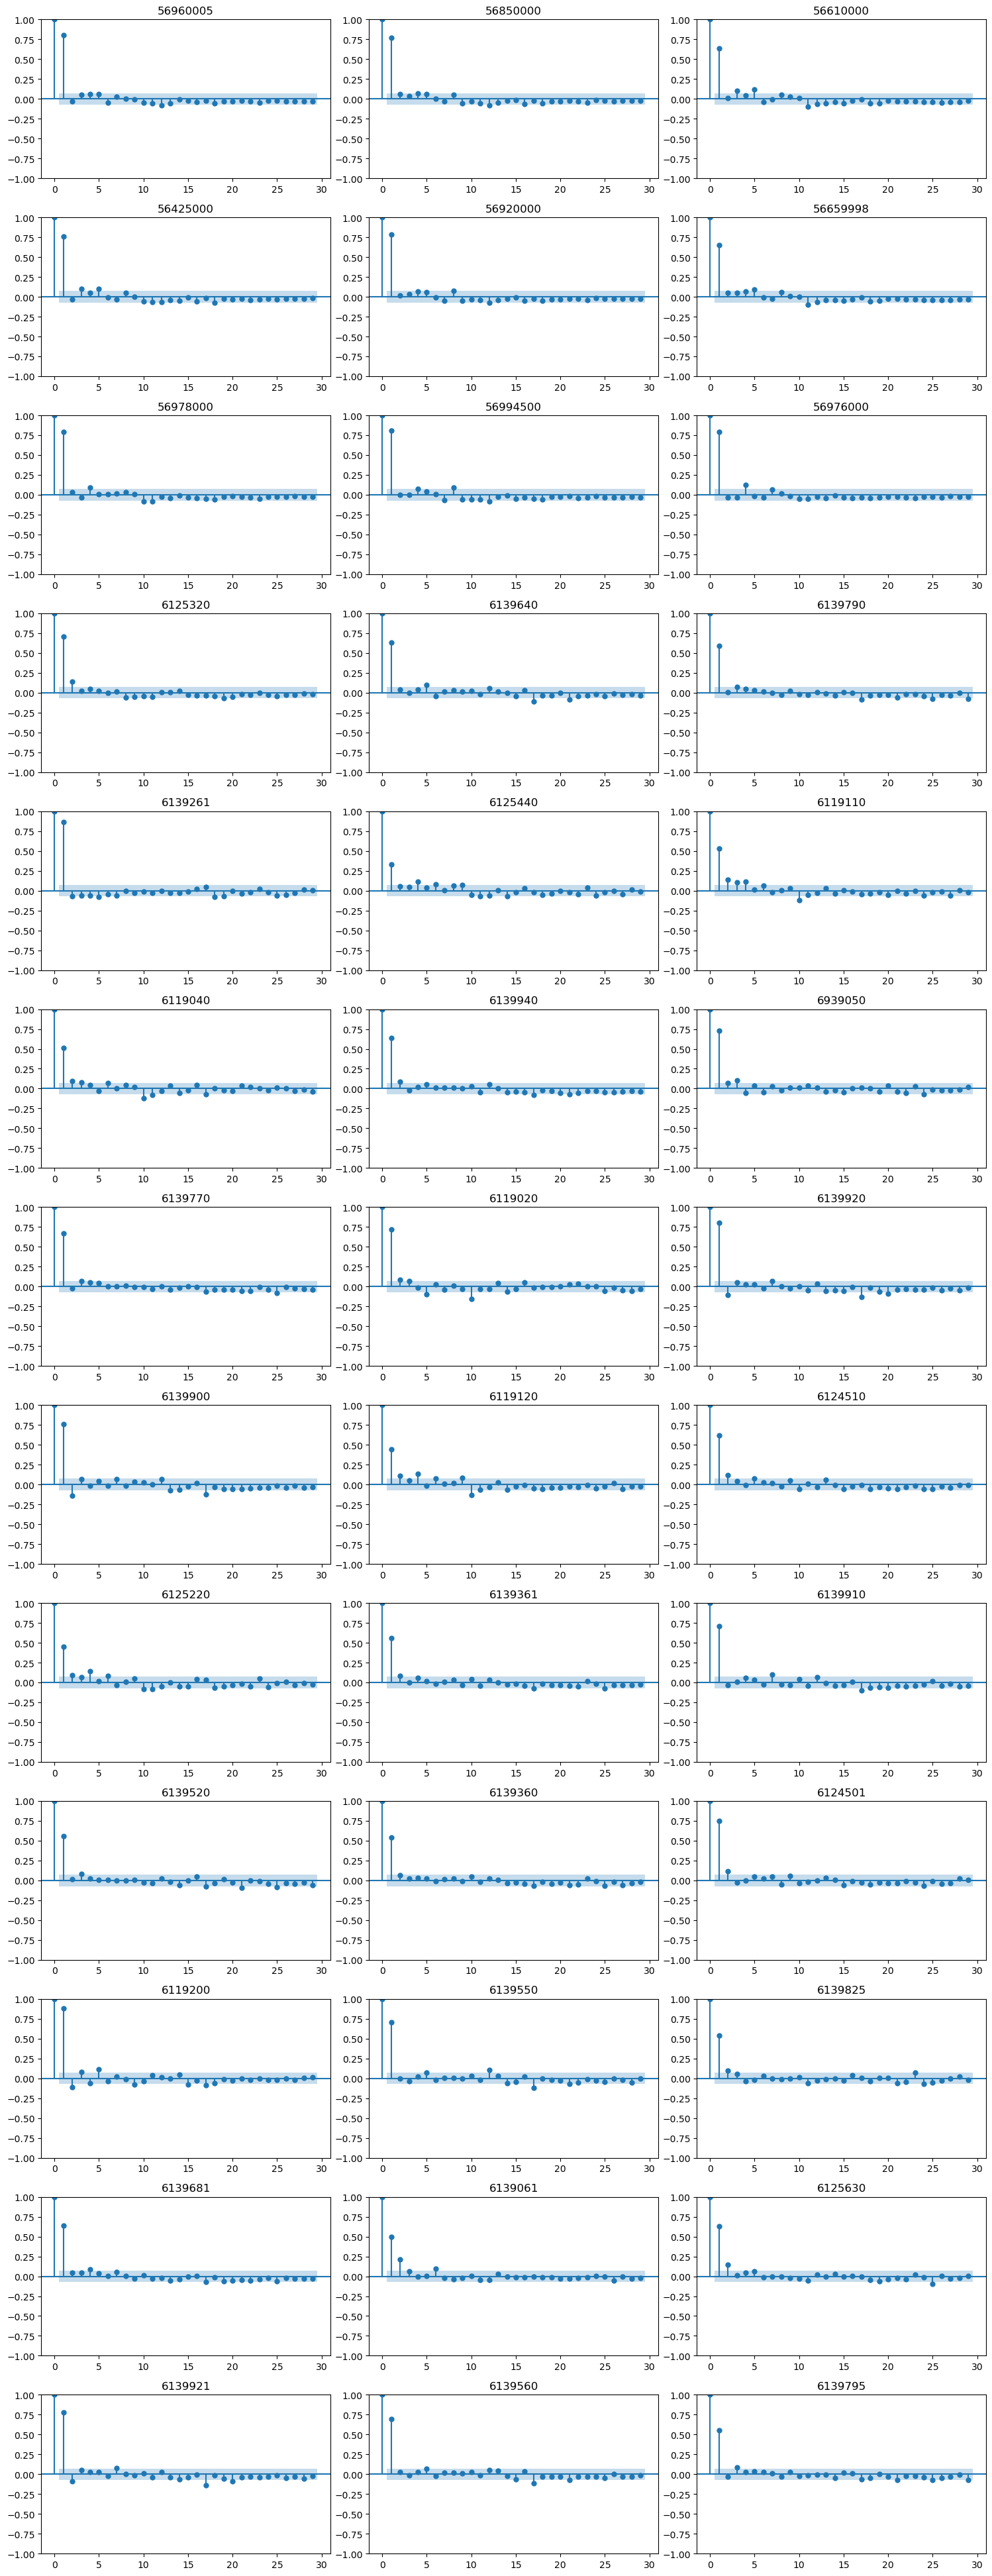

In [27]:
fig, ax = plt.subplots(13, 3, figsize = (15, 39))
ax = ax.flatten()
for i, sc in enumerate(df_train.station_code.unique()):
    temp = df_train[df_train.station_code == sc]
    t_pacf = pacf(temp.discharge)
    plot_pacf(temp.discharge, ax = ax[i])
    ax[i].set_title(sc)
plt.tight_layout()

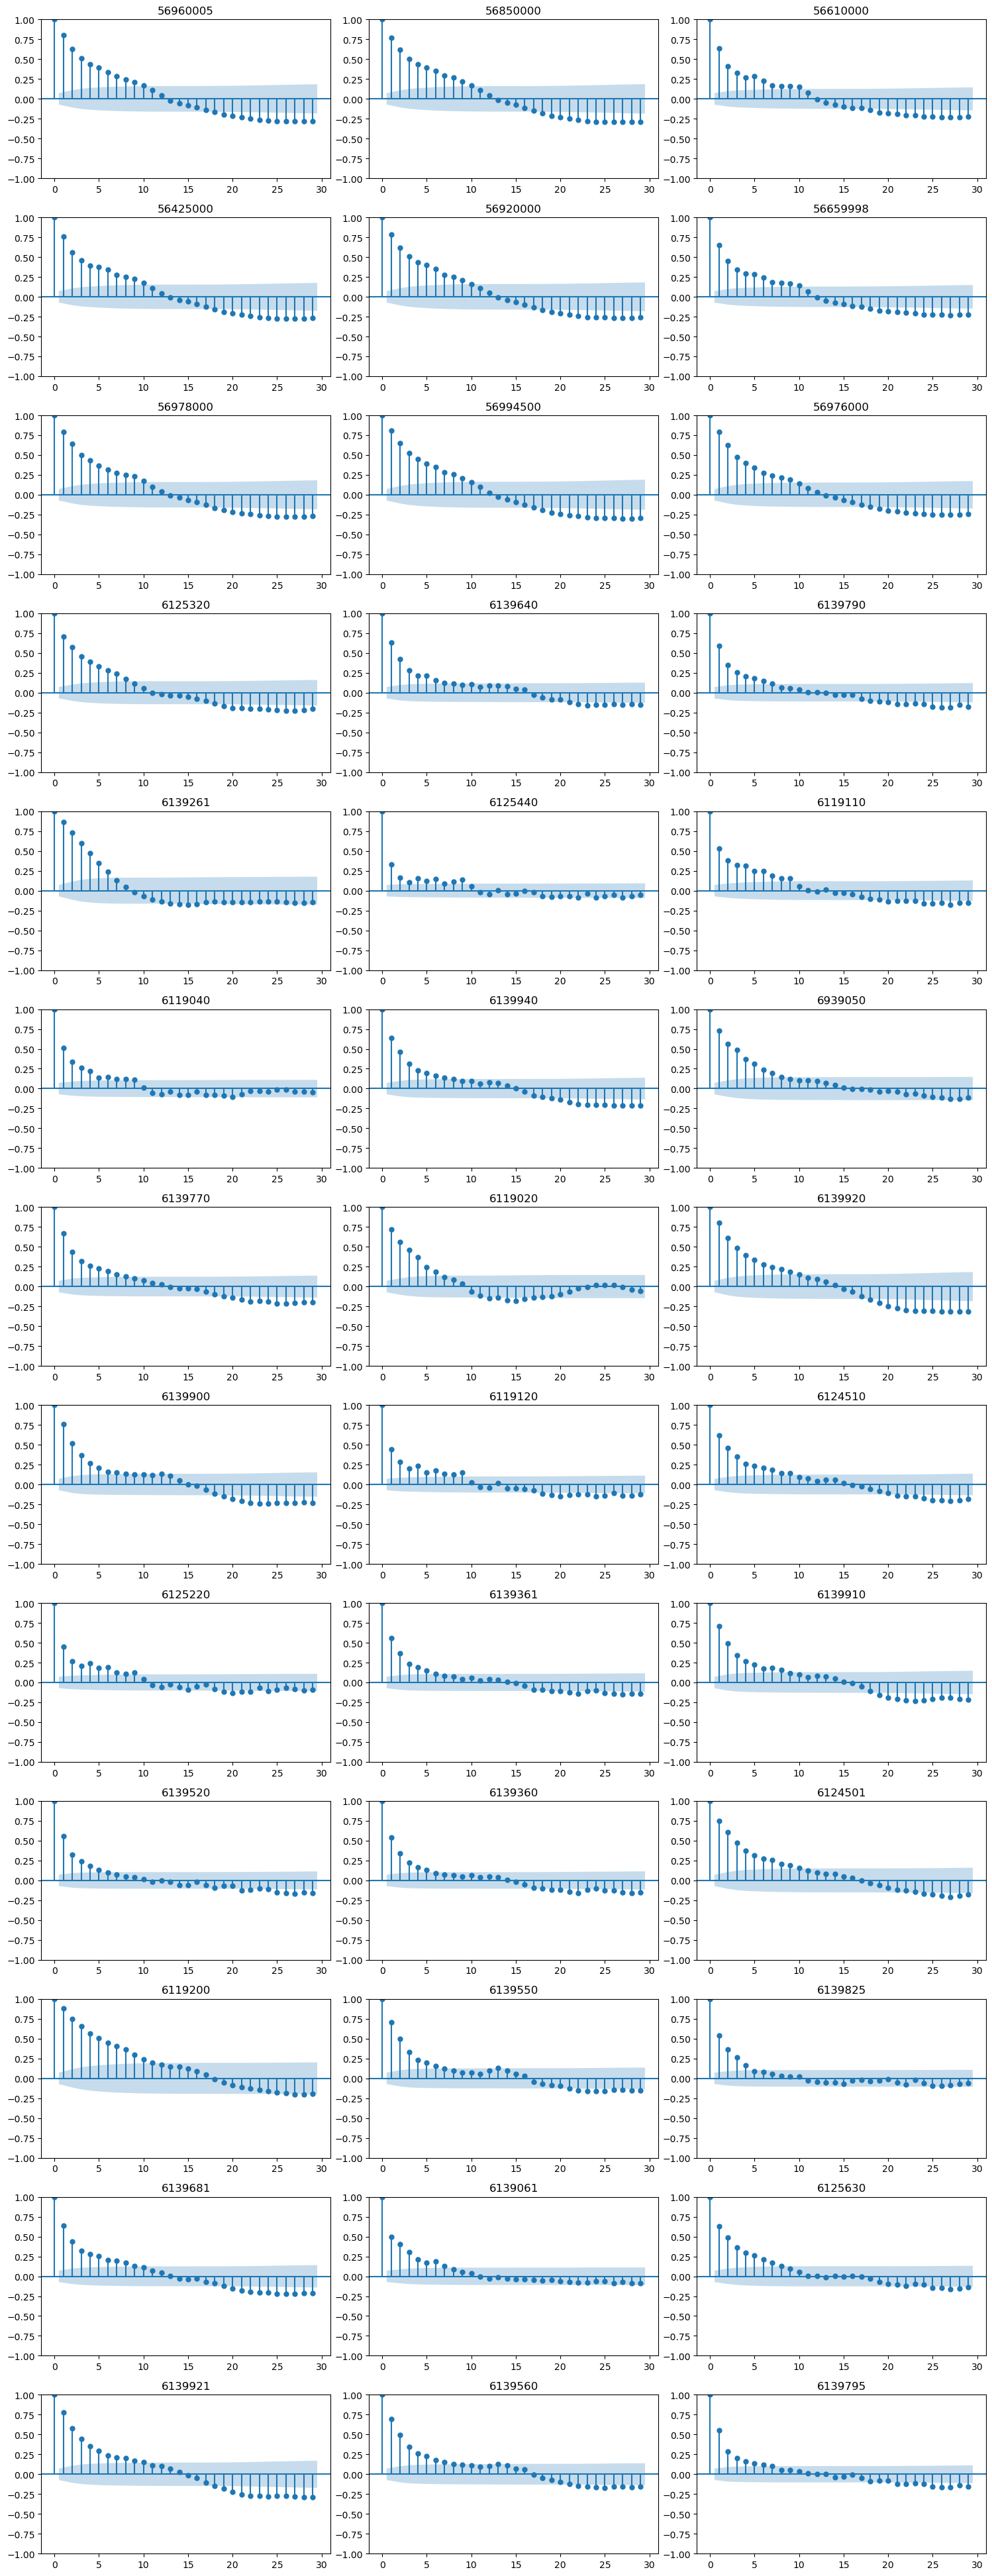

In [28]:
samp = sample = df_['tr_brazil']
fig, ax = plt.subplots(13, 3, figsize = (15, 39))
ax = ax.flatten()
for i, sc in enumerate(df_train.station_code.unique()):
    temp = df_train[df_train.station_code == sc]
    plot_acf(temp.discharge, ax = ax[i])
    ax[i].set_title(sc)
plt.tight_layout()

In [29]:
df_train = df_train.sort_values(['station_code', 'ObsDate'])
df_eval = df_eval.sort_values(['station_code', 'ObsDate'])

In [32]:
for df in [df_train, df_eval]:
    df['water_flow_lag_1w'] = df.groupby('station_code').discharge.shift(1).bfill()
    df['water_flow_lag_2w'] = df.groupby('station_code').discharge.shift(2).bfill()
    df['water_flow_rolling_mean_4w'] = df.groupby('station_code').discharge.shift(1).rolling(4).mean().bfill()

In [33]:
df_train['tp_evap_diff'] = df_train.tp + df_train.evap
df_eval['tp_evap_diff'] = df_eval.tp + df_eval.evap

In [34]:
NUM_METEO = ['tp', 't2m', 'swvl1', 'evap']

In [35]:
for df in [df_train, df_eval]:
    for col in df.filter(regex = '|'.join(NUM_METEO)).columns:
        if 'tp' in col or 'evap' in col :
            df[f'{col}_rolling_sum_3w'] = df.groupby('station_code')[col].rolling(3).sum().bfill().values
        elif 't2m' in col or 'swvl1' in col:
            df[f'{col}_rolling_mean_3w'] = df.groupby('station_code')[col].rolling(3).mean().bfill().values
        df[f'{col}_lag_1w'] = df.groupby('station_code')[col].shift(1).bfill().values
    

In [36]:
# for col in df_train.filter(regex = '|'.join(NUM_METEO)).columns:
#     if 'tp' in col or 'evap' in col :
#         df_train[f'{col}_rolling_sum_3w'] = df_train.groupby('station_code')[col].rolling(3).sum().bfill().values
#     elif 't2m' in col or 'swvl1' in col:
#         df_train[f'{col}_rolling_mean_3w'] = df_train.groupby('station_code')[col].rolling(3).mean().bfill().values
#     df_train[f'{col}_lag_1w'] = df_train.groupby('station_code')[col].shift(1).bfill().values

In [37]:
# for col in df_eval.filter(regex = '|'.join(NUM_METEO)).columns:
#     if 'tp' in col or 'evap' in col :
#         df_eval[f'{col}_rolling_sum_3'] = df_eval.groupby('station_code')[col].rolling(3).sum().bfill().values
#     elif 't2m' in col or 'swvl1' in col:
#         df_eval[f'{col}_rolling_mean_3'] = df_eval.groupby('station_code')[col].rolling(3).mean().bfill().values
#     df_eval[f'{col}_lag_1w'] = df_eval.groupby('station_code')[col].shift(1).bfill().values

In [38]:
df_eval

,station_code,ObsDate,tp,tp_50km,tp_100km,t2m,t2m_50km,t2m_100km,swvl1,swvl1_50km,...,swvl1_100km_rolling_mean_3w,swvl1_100km_lag_1w,evap_rolling_sum_3w,evap_lag_1w,evap_50km_rolling_sum_3w,evap_50km_lag_1w,evap_100km_rolling_sum_3w,evap_100km_lag_1w,tp_evap_diff_rolling_sum_3w,tp_evap_diff_lag_1w
3380,6119020,2004-01-04,0.000257,0.000290,0.000211,276.70303,275.12015,275.41705,0.413939,0.415141,...,0.391809,0.393627,-0.000084,-0.000017,-0.000067,-0.000015,-0.000088,-0.000024,0.000590,0.000240
3381,6119020,2004-01-11,0.000166,0.000165,0.000144,281.04352,279.39310,279.44280,0.399103,0.404816,...,0.391809,0.393627,-0.000084,-0.000017,-0.000067,-0.000015,-0.000088,-0.000024,0.000590,0.000240
3382,6119020,2004-01-18,0.000251,0.000272,0.000242,282.28690,280.36356,280.72880,0.405925,0.415607,...,0.391809,0.385959,-0.000084,-0.000025,-0.000067,-0.000018,-0.000088,-0.000022,0.000590,0.000141
3383,6119020,2004-01-25,0.000371,0.000391,0.000294,279.98422,278.40518,278.96353,0.411808,0.418629,...,0.392860,0.395841,-0.000087,-0.000042,-0.000068,-0.000034,-0.000086,-0.000042,0.000702,0.000209
3384,6119020,2004-02-01,0.000224,0.000231,0.000194,279.28950,277.59244,277.80180,0.411699,0.416467,...,0.397312,0.396780,-0.000094,-0.000020,-0.000076,-0.000016,-0.000097,-0.000022,0.000752,0.000351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,56994500,2009-10-04,0.000015,0.000013,0.000025,297.28207,297.04828,296.68277,0.193479,0.226604,...,0.254210,0.246295,-0.000192,-0.000055,-0.000199,-0.000059,-0.000228,-0.000067,-0.000155,-0.000053
1426,56994500,2009-10-11,0.000394,0.000387,0.000337,297.60284,297.34772,296.91100,0.262132,0.288465,...,0.266262,0.252509,-0.000211,-0.000070,-0.000215,-0.000070,-0.000247,-0.000086,0.000200,-0.000056
1427,56994500,2009-10-18,0.000020,0.000029,0.000044,298.88130,298.67664,298.24356,0.314147,0.337719,...,0.294287,0.299982,-0.000282,-0.000085,-0.000280,-0.000086,-0.000300,-0.000094,0.000147,0.000309
1428,56994500,2009-10-25,0.000122,0.000144,0.000151,299.06570,298.87115,298.51065,0.294177,0.327786,...,0.321730,0.330368,-0.000326,-0.000126,-0.000325,-0.000124,-0.000332,-0.000120,0.000210,-0.000106


### add future predictions and rename current

In [39]:
df_train['water_flow_week_1'] = df_train.discharge
df_train['water_flow_week_2'] = df_train.groupby('station_code').discharge.shift(-1)
df_train['water_flow_week_3'] = df_train.groupby('station_code').discharge.shift(-2)
df_train['water_flow_week_4'] = df_train.groupby('station_code').discharge.shift(-3)
df_train = df_train.drop(columns = ['discharge'])

In [43]:
# Only keep the inference rows
missing_values = df_eval["discharge"].isnull()
df_eval = df_eval[missing_values]
df_eval = df_eval.drop(columns = 'discharge', errors = 'ignore')

In [44]:
set(df_eval.columns).symmetric_difference(set(df_train.columns))

{'dataset',
 'water_flow_week_1',
 'water_flow_week_2',
 'water_flow_week_3',
 'water_flow_week_4'}

In [45]:
df_eval.shape, df_train.shape

((1390, 215), (28509, 218))

<Axes: >

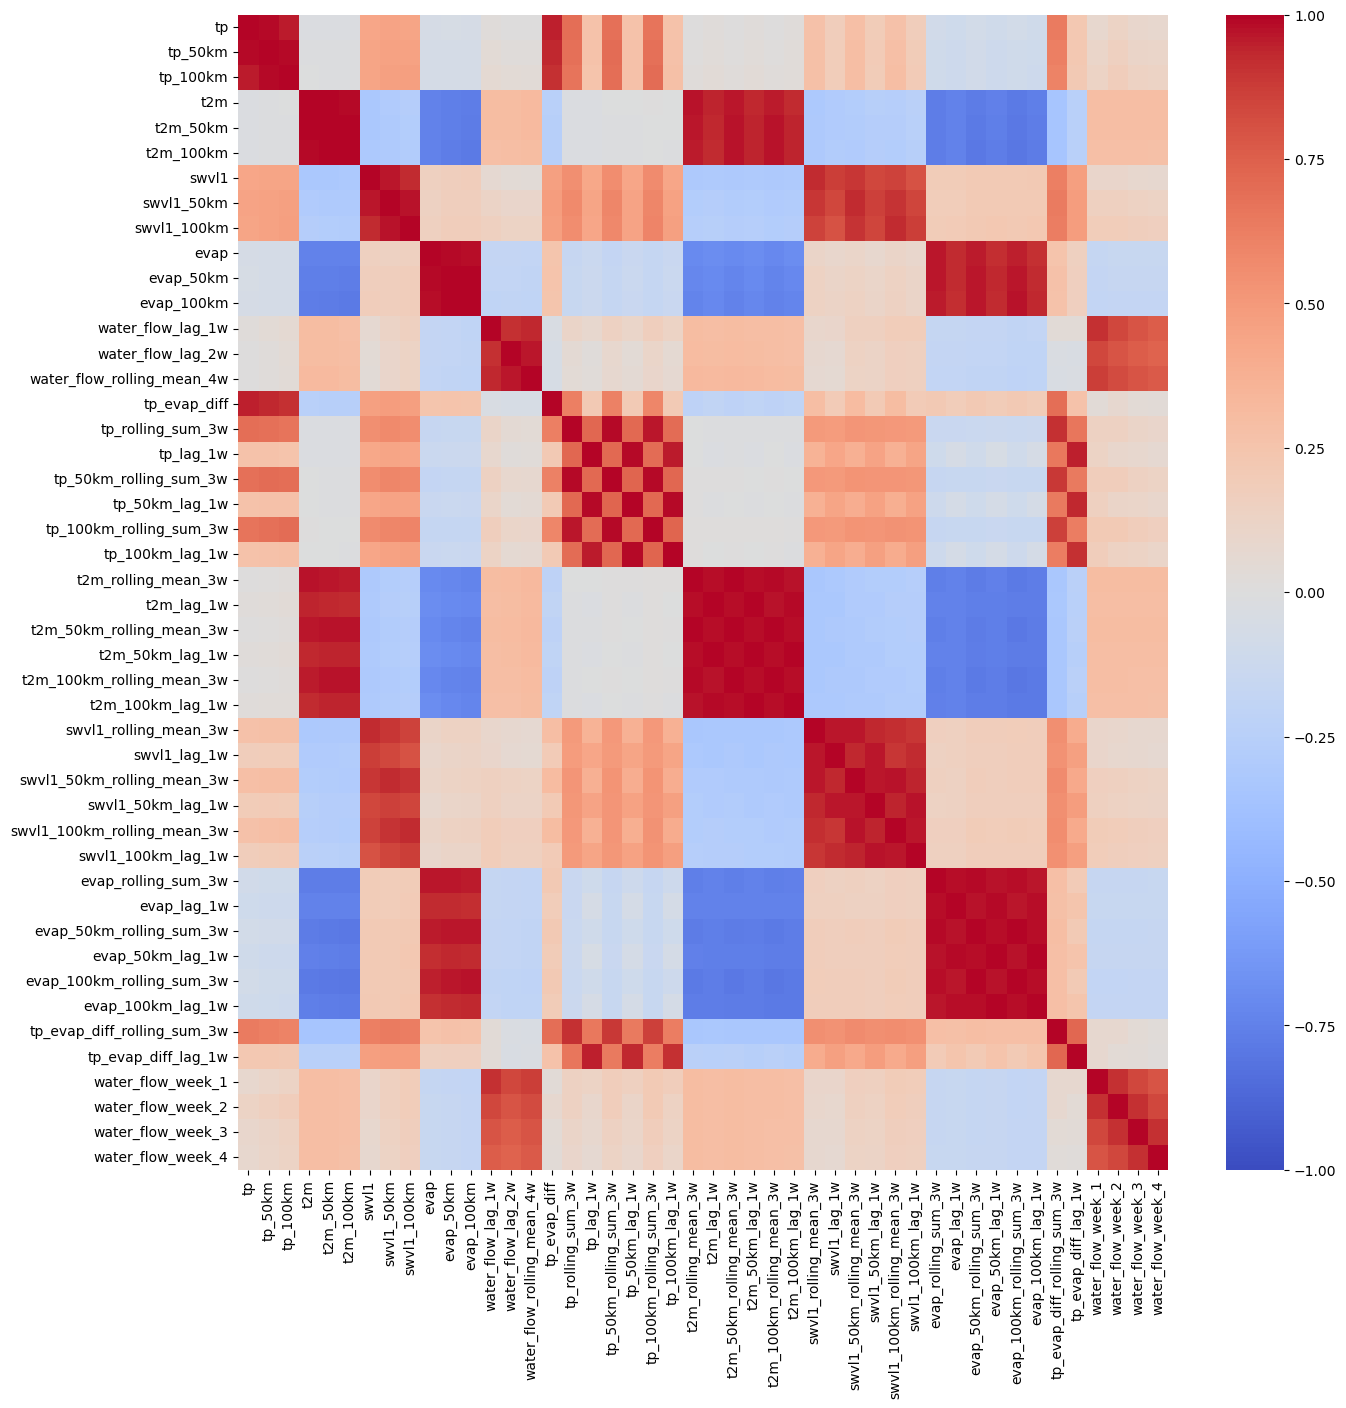

In [93]:
plt.figure(figsize = (15, 15))
sns.heatmap(df_train.filter(regex = 'discharge|water_flow|' + '|'.join(NUM_METEO)).corr(), cmap = 'coolwarm', vmin = -1.0, vmax = 1.0)